In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import platform
import os
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

In [3]:
# 1. 폰트 파일 경로 설정
font_path = r"C:\Users\User\Desktop\MyRepo\Portfolio\Portfolio_ver2\5_fonts\Pretendard-Medium.otf"

# 2. 폰트 이름 가져오기
font_name = fm.FontProperties(fname = font_path).get_name()
fm.fontManager.addfont(font_path)

# 3. Matplotlib의 기본 폰트로 설정
plt.rc("font", family = font_name)

# 4. 마이너스 기호 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

print(f"설정된 폰트 이름: {font_name}")

설정된 폰트 이름: Pretendard


In [4]:
df = pd.read_csv(r"C:\Users\User\Desktop\MyRepo\Portfolio\Portfolio_ver2\1_data\processed\df_final_v2.csv")
df["datetime"] = pd.to_datetime(df["datetime"])

## 1. BASELINE (시간 변수 + 요일 및 휴일 변수) 반영

학습: (8591, 6) / 테스트: (8784, 6)
Linear Regression    | R²: 0.2431 | RMSE: 1310.0 | MAPE: 16.98%
Random Forest        | R²: 0.8115 | RMSE: 653.7 | MAPE: 8.77%
XGBoost              | R²: 0.8126 | RMSE: 651.8 | MAPE: 8.75%


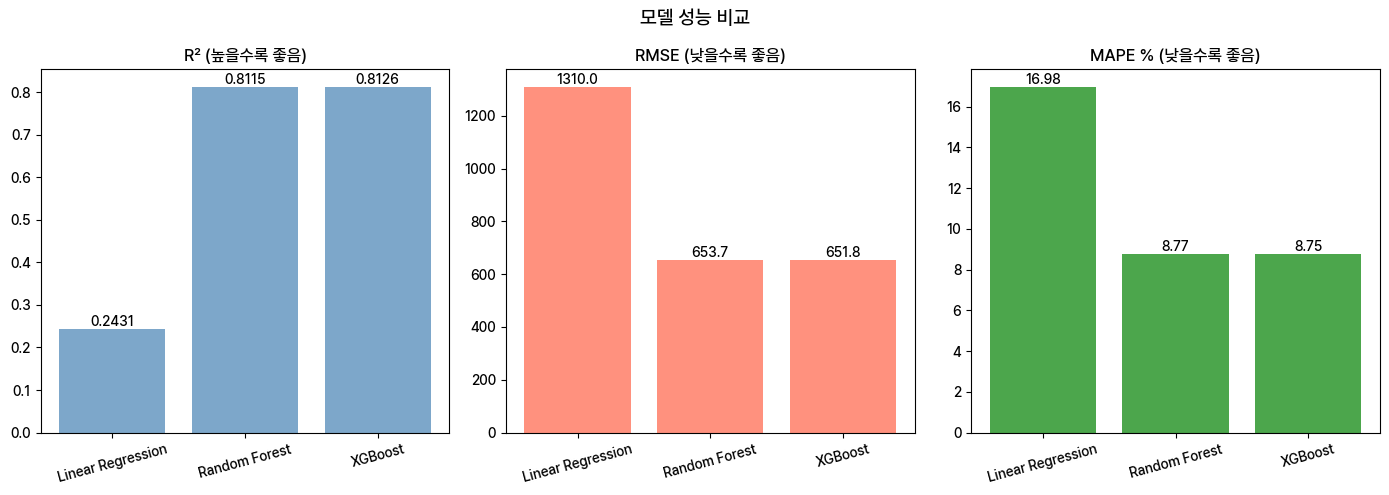

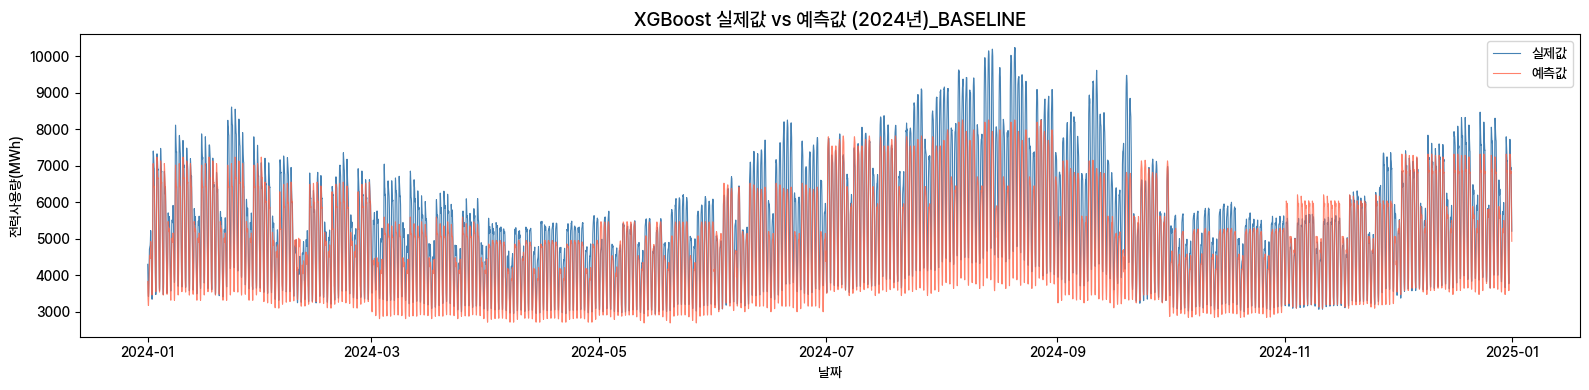

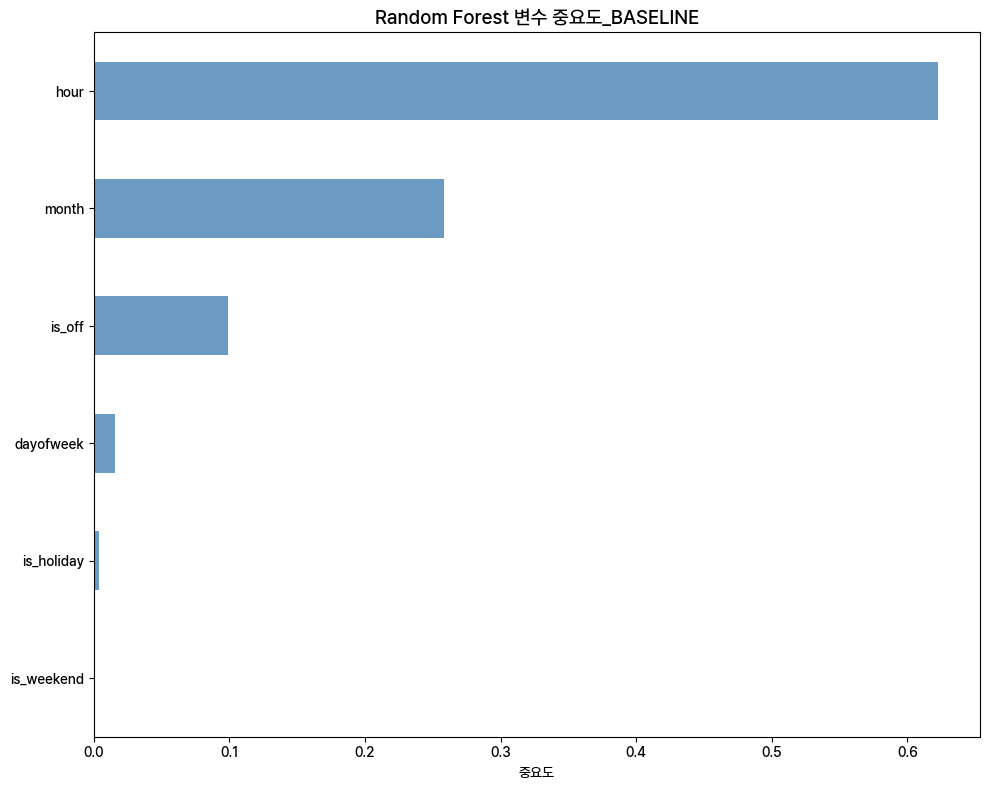

In [5]:
# ── 피처 / 타겟 정의 ────────────────────────────
FEATURES_BASELINE = [
    "hour", "dayofweek", "month",
    "is_weekend", "is_holiday", "is_off",
]
TARGET = "전력사용량(MWh)"

# 강수량 NaN → 0, 일사량 NaN → 0
df["강수량(mm)"] = df["강수량(mm)"].fillna(0)
df["일사(MJ/m2)"] = df["일사(MJ/m2)"].fillna(0)

# ── 학습/테스트 분리 (2023 → 2024) ─────────────
train = df[df["datetime"].dt.year == 2023]
test  = df[df["datetime"].dt.year == 2024]

X_train = train[FEATURES_BASELINE]
y_train = train[TARGET]
X_test  = test[FEATURES_BASELINE]
y_test  = test[TARGET]

print(f"학습: {X_train.shape} / 테스트: {X_test.shape}")

# ── 모델 학습 ───────────────────────────────────
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest":     RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost":           XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42, n_jobs=-1)
}

results_baseline = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    results_baseline[name] = {
        "model": model,
        "pred": pred,
        "R2":   round(r2_score(y_test, pred), 4),
        "RMSE": round(np.sqrt(mean_squared_error(y_test, pred)), 1),
        "MAPE": round(mean_absolute_percentage_error(y_test, pred) * 100, 2)
    }
    print(f"{name:20s} | R²: {results_baseline[name]['R2']} | RMSE: {results_baseline[name]['RMSE']} | MAPE: {results_baseline[name]['MAPE']}%")

# ── 성능 비교표 시각화 ──────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
metrics = ["R2", "RMSE", "MAPE"]
titles  = ["R² (높을수록 좋음)", "RMSE (낮을수록 좋음)", "MAPE % (낮을수록 좋음)"]
colors  = ["steelblue", "tomato", "green"]

for i, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
    vals = [results_baseline[m][metric] for m in models]
    axes[i].bar(list(models.keys()), vals, color=color, alpha=0.7)
    axes[i].set_title(title, fontsize=12)
    for j, v in enumerate(vals):
        axes[i].text(j, v, str(v), ha="center", va="bottom", fontsize=10)
    axes[i].tick_params(axis='x', rotation=15)

plt.suptitle("모델 성능 비교", fontsize=14)
plt.tight_layout()
plt.savefig(r"C:\Users\User\Desktop\MyRepo\Portfolio\Portfolio_ver2\4_outputs\모델_성능비교_BASELINE.png", dpi=300)
plt.show()

# ── 실제값 vs 예측값 시각화 (XGBoost) ──────────
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(test["datetime"].values, y_test.values, label="실제값", color="steelblue", linewidth=0.8)
ax.plot(test["datetime"].values, results_baseline["XGBoost"]["pred"], label="예측값", color="tomato", linewidth=0.8, alpha=0.8)
ax.set_title("XGBoost 실제값 vs 예측값 (2024년)_BASELINE", fontsize=14)
ax.set_xlabel("날짜")
ax.set_ylabel("전력사용량(MWh)")
ax.legend()
plt.tight_layout()
plt.savefig(r"C:\Users\User\Desktop\MyRepo\Portfolio\Portfolio_ver2\4_outputs\실제vs예측_BASELINE.png", dpi=300)
plt.show()

# ── 변수 중요도 (Random Forest) ─────────────────
fi = pd.Series(
    results_baseline["Random Forest"]["model"].feature_importances_,
    index=FEATURES_BASELINE
).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
fi.plot(kind="barh", ax=ax, color="steelblue", alpha=0.8)
ax.set_title("Random Forest 변수 중요도_BASELINE", fontsize=14)
ax.set_xlabel("중요도")
plt.tight_layout()
plt.savefig(r"C:\Users\User\Desktop\MyRepo\Portfolio\Portfolio_ver2\4_outputs\변수중요도_BASELINE.png", dpi=300)
plt.show()

## 2. LAG MODEL (시간 변수 + 요일 및 휴일 변수 + lag 변수) 반영

학습: (8591, 9) / 테스트: (8784, 9)
Linear Regression    | R²: 0.9378 | RMSE: 375.6 | MAPE: 5.0%
Random Forest        | R²: 0.9646 | RMSE: 283.4 | MAPE: 3.15%
XGBoost              | R²: 0.9715 | RMSE: 254.2 | MAPE: 2.89%


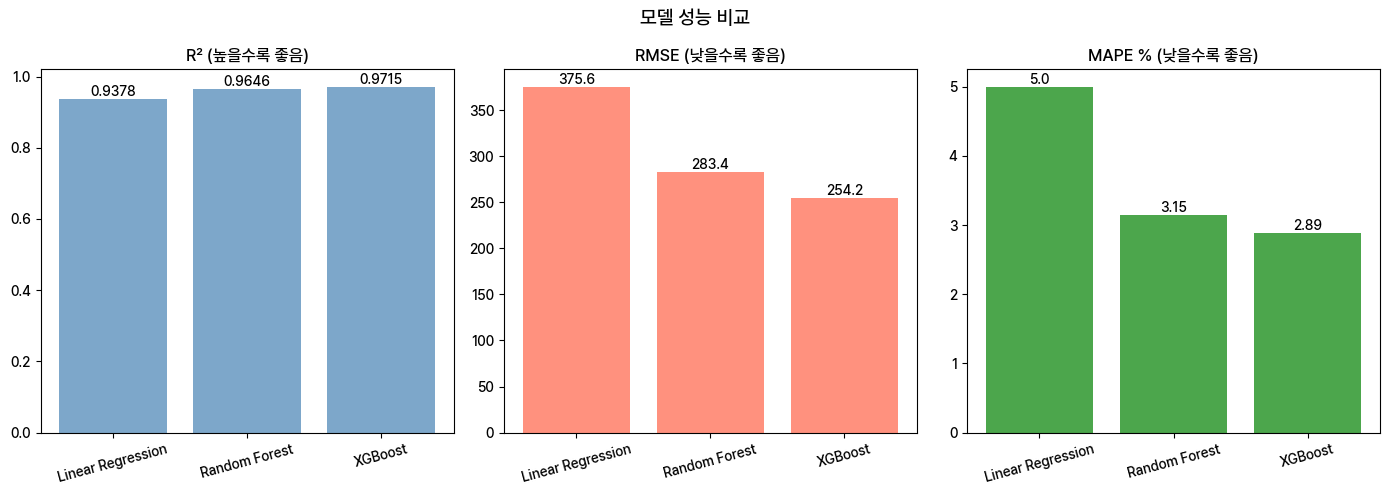

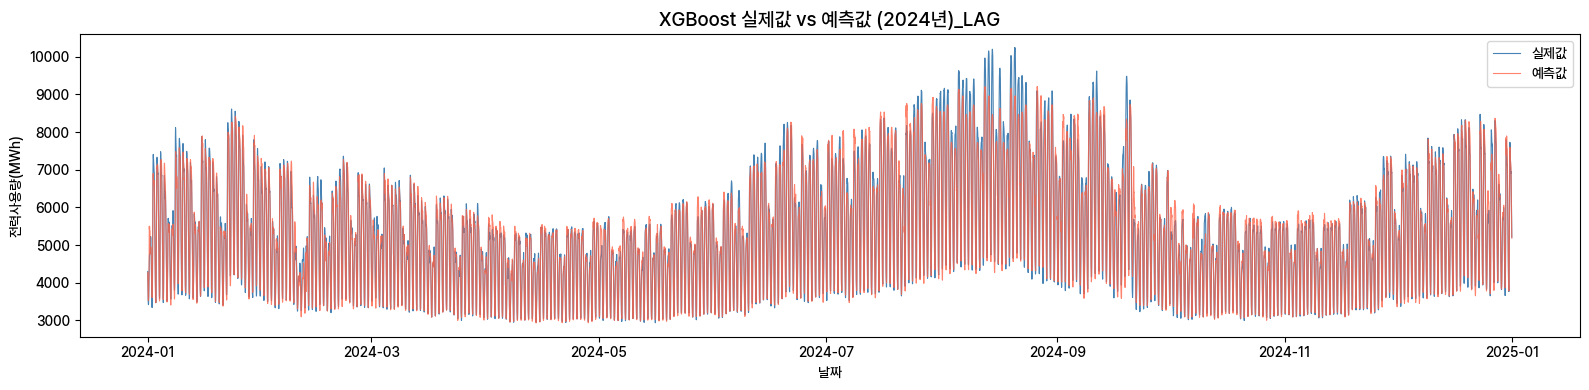

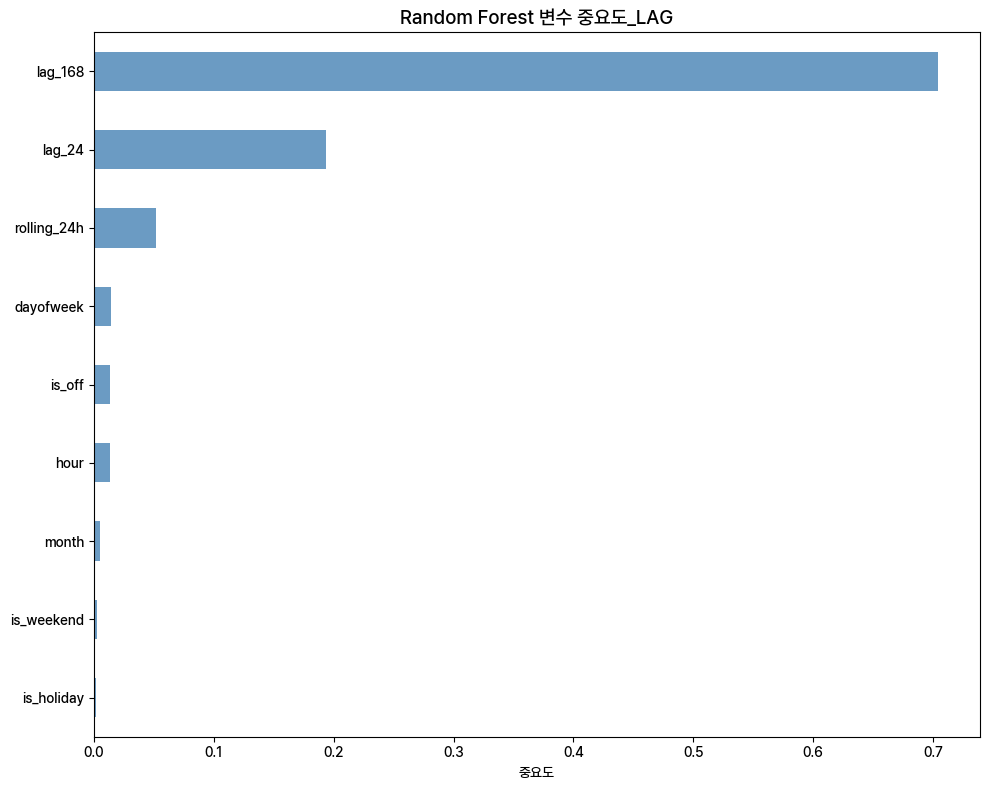

In [6]:
# ── 피처 / 타겟 정의 ────────────────────────────
FEATURES_LAG = [
    "hour", "dayofweek", "month",
    "is_weekend", "is_holiday", "is_off",
    "lag_24", "lag_168", "rolling_24h"
]
TARGET = "전력사용량(MWh)"

# 강수량 NaN → 0, 일사량 NaN → 0
df["강수량(mm)"] = df["강수량(mm)"].fillna(0)
df["일사(MJ/m2)"] = df["일사(MJ/m2)"].fillna(0)

# ── 학습/테스트 분리 (2023 → 2024) ─────────────
train = df[df["datetime"].dt.year == 2023]
test  = df[df["datetime"].dt.year == 2024]

X_train = train[FEATURES_LAG]
y_train = train[TARGET]
X_test  = test[FEATURES_LAG]
y_test  = test[TARGET]

print(f"학습: {X_train.shape} / 테스트: {X_test.shape}")

# ── 모델 학습 ───────────────────────────────────
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest":     RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost":           XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42, n_jobs=-1)
}

results_lag = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    results_lag[name] = {
        "model": model,
        "pred": pred,
        "R2":   round(r2_score(y_test, pred), 4),
        "RMSE": round(np.sqrt(mean_squared_error(y_test, pred)), 1),
        "MAPE": round(mean_absolute_percentage_error(y_test, pred) * 100, 2)
    }
    print(f"{name:20s} | R²: {results_lag[name]['R2']} | RMSE: {results_lag[name]['RMSE']} | MAPE: {results_lag[name]['MAPE']}%")

# ── 성능 비교표 시각화 ──────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
metrics = ["R2", "RMSE", "MAPE"]
titles  = ["R² (높을수록 좋음)", "RMSE (낮을수록 좋음)", "MAPE % (낮을수록 좋음)"]
colors  = ["steelblue", "tomato", "green"]

for i, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
    vals = [results_lag[m][metric] for m in models]
    axes[i].bar(list(models.keys()), vals, color=color, alpha=0.7)
    axes[i].set_title(title, fontsize=12)
    for j, v in enumerate(vals):
        axes[i].text(j, v, str(v), ha="center", va="bottom", fontsize=10)
    axes[i].tick_params(axis='x', rotation=15)

plt.suptitle("모델 성능 비교", fontsize=14)
plt.tight_layout()
plt.savefig(r"C:\Users\User\Desktop\MyRepo\Portfolio\Portfolio_ver2\4_outputs\모델_성능비교_LAG.png", dpi=300)
plt.show()

# ── 실제값 vs 예측값 시각화 (XGBoost) ──────────
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(test["datetime"].values, y_test.values, label="실제값", color="steelblue", linewidth=0.8)
ax.plot(test["datetime"].values, results_lag["XGBoost"]["pred"], label="예측값", color="tomato", linewidth=0.8, alpha=0.8)
ax.set_title("XGBoost 실제값 vs 예측값 (2024년)_LAG", fontsize=14)
ax.set_xlabel("날짜")
ax.set_ylabel("전력사용량(MWh)")
ax.legend()
plt.tight_layout()
plt.savefig(r"C:\Users\User\Desktop\MyRepo\Portfolio\Portfolio_ver2\4_outputs\실제vs예측_LAG.png", dpi=300)
plt.show()

# ── 변수 중요도 (Random Forest) ─────────────────
fi = pd.Series(
    results_lag["Random Forest"]["model"].feature_importances_,
    index=FEATURES_LAG
).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
fi.plot(kind="barh", ax=ax, color="steelblue", alpha=0.8)
ax.set_title("Random Forest 변수 중요도_LAG", fontsize=14)
ax.set_xlabel("중요도")
plt.tight_layout()
plt.savefig(r"C:\Users\User\Desktop\MyRepo\Portfolio\Portfolio_ver2\4_outputs\변수중요도_LAG.png", dpi=300)
plt.show()

## 3. ENV MODEL (시간 변수 + 요일 및 휴일 변수 + 환경 변수) 반영

학습: (8591, 19) / 테스트: (8784, 19)
Linear Regression    | R²: 0.6391 | RMSE: 904.6 | MAPE: 13.02%
Random Forest        | R²: 0.8898 | RMSE: 499.8 | MAPE: 7.6%
XGBoost              | R²: 0.8993 | RMSE: 477.7 | MAPE: 7.59%


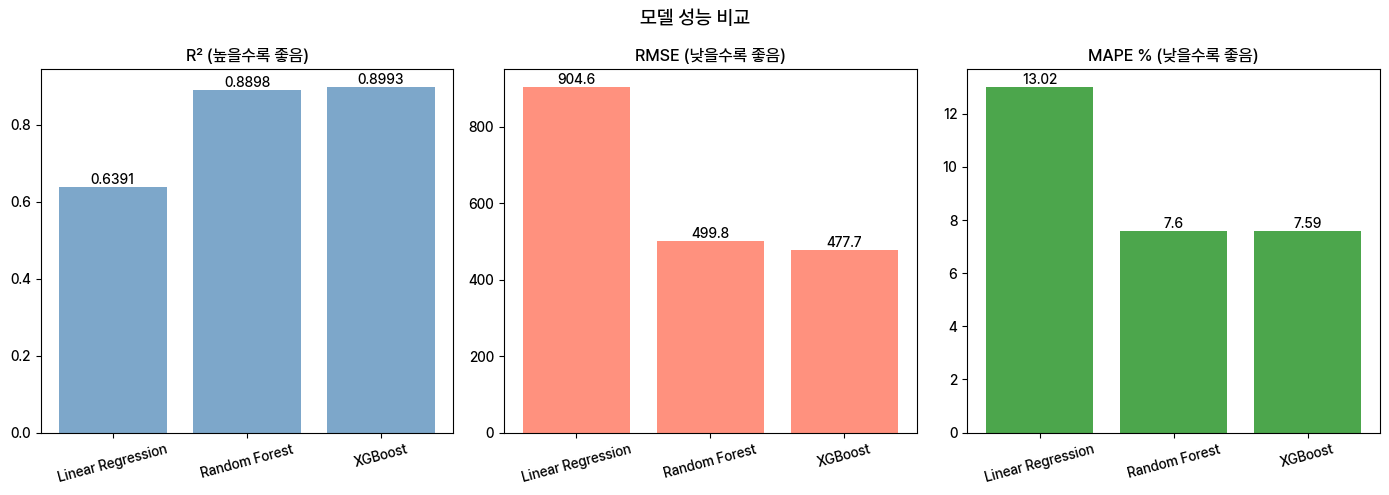

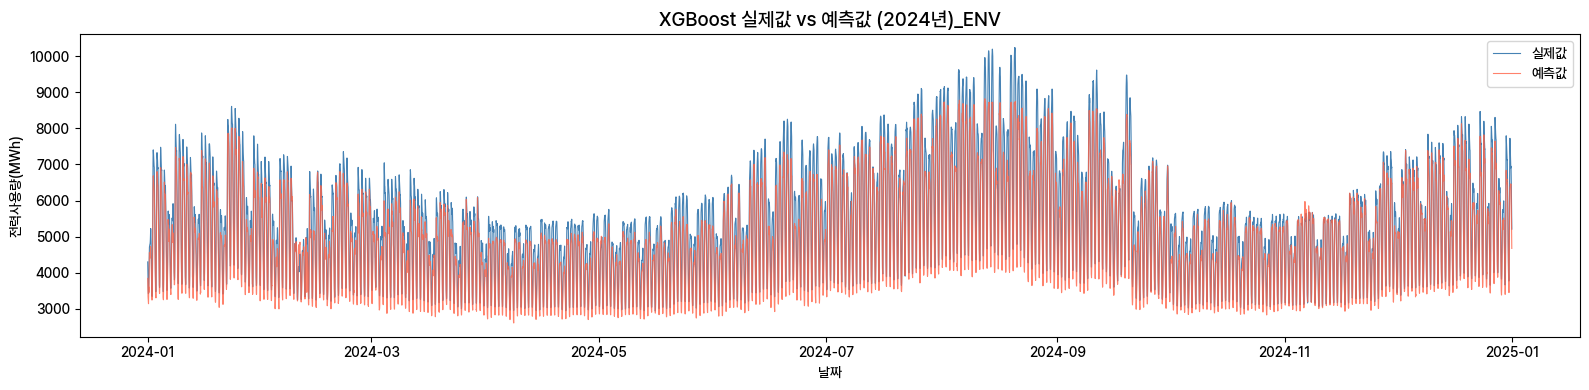

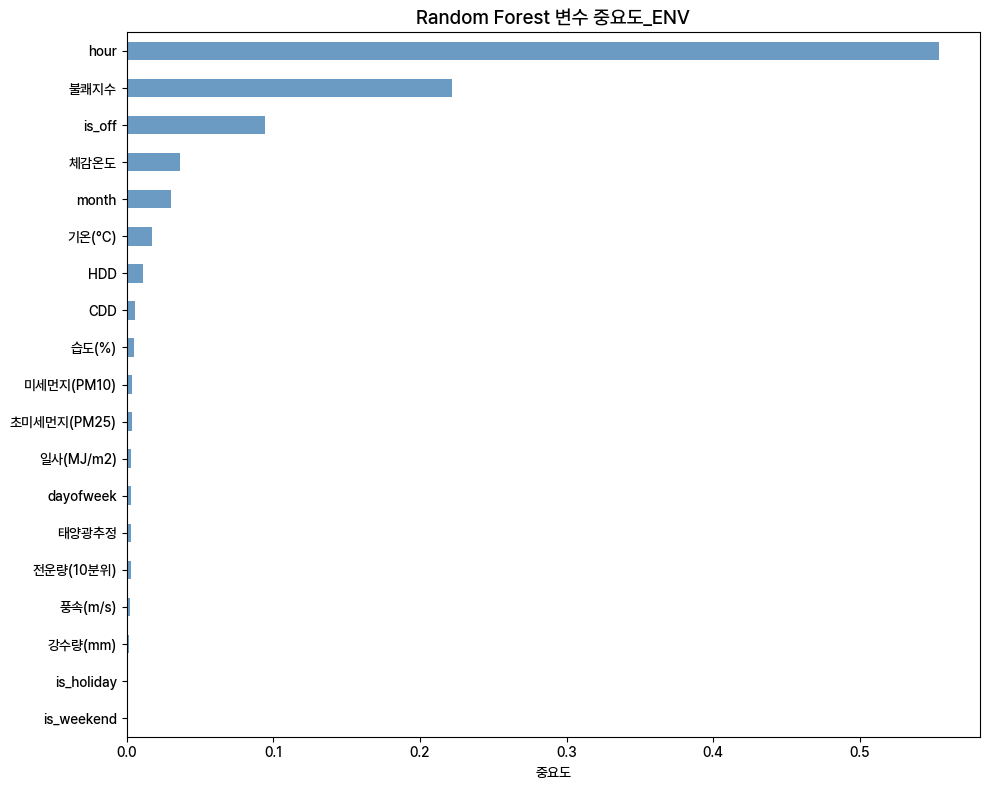

In [7]:
# ── 피처 / 타겟 정의 ────────────────────────────
FEATURES_ENV = [
    "기온(°C)", "강수량(mm)", "풍속(m/s)", "습도(%)", "일사(MJ/m2)", "전운량(10분위)",
    "미세먼지(PM10)", "초미세먼지(PM25)",
    "hour", "dayofweek", "month", "is_weekend", "is_holiday", "is_off",
    "CDD", "HDD", "체감온도", "불쾌지수", "태양광추정"
]
TARGET = "전력사용량(MWh)"

# 강수량 NaN → 0, 일사량 NaN → 0
df["강수량(mm)"] = df["강수량(mm)"].fillna(0)
df["일사(MJ/m2)"] = df["일사(MJ/m2)"].fillna(0)

# ── 학습/테스트 분리 (2023 → 2024) ─────────────
train = df[df["datetime"].dt.year == 2023]
test  = df[df["datetime"].dt.year == 2024]

X_train = train[FEATURES_ENV]
y_train = train[TARGET]
X_test  = test[FEATURES_ENV]
y_test  = test[TARGET]

print(f"학습: {X_train.shape} / 테스트: {X_test.shape}")

# ── 모델 학습 ───────────────────────────────────
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest":     RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost":           XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42, n_jobs=-1)
}

results_env = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    results_env[name] = {
        "model": model,
        "pred": pred,
        "R2":   round(r2_score(y_test, pred), 4),
        "RMSE": round(np.sqrt(mean_squared_error(y_test, pred)), 1),
        "MAPE": round(mean_absolute_percentage_error(y_test, pred) * 100, 2)
    }
    print(f"{name:20s} | R²: {results_env[name]['R2']} | RMSE: {results_env[name]['RMSE']} | MAPE: {results_env[name]['MAPE']}%")

# ── 성능 비교표 시각화 ──────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
metrics = ["R2", "RMSE", "MAPE"]
titles  = ["R² (높을수록 좋음)", "RMSE (낮을수록 좋음)", "MAPE % (낮을수록 좋음)"]
colors  = ["steelblue", "tomato", "green"]

for i, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
    vals = [results_env[m][metric] for m in models]
    axes[i].bar(list(models.keys()), vals, color=color, alpha=0.7)
    axes[i].set_title(title, fontsize=12)
    for j, v in enumerate(vals):
        axes[i].text(j, v, str(v), ha="center", va="bottom", fontsize=10)
    axes[i].tick_params(axis='x', rotation=15)

plt.suptitle("모델 성능 비교", fontsize=14)
plt.tight_layout()
plt.savefig(r"C:\Users\User\Desktop\MyRepo\Portfolio\Portfolio_ver2\4_outputs\모델_성능비교_env.png", dpi=300)
plt.show()

# ── 실제값 vs 예측값 시각화 (XGBoost) ──────────
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(test["datetime"].values, y_test.values, label="실제값", color="steelblue", linewidth=0.8)
ax.plot(test["datetime"].values, results_env["XGBoost"]["pred"], label="예측값", color="tomato", linewidth=0.8, alpha=0.8)
ax.set_title("XGBoost 실제값 vs 예측값 (2024년)_ENV", fontsize=14)
ax.set_xlabel("날짜")
ax.set_ylabel("전력사용량(MWh)")
ax.legend()
plt.tight_layout()
plt.savefig(r"C:\Users\User\Desktop\MyRepo\Portfolio\Portfolio_ver2\4_outputs\실제vs예측_env.png", dpi=300)
plt.show()

# ── 변수 중요도 (Random Forest) ─────────────────
fi = pd.Series(
    results_env["Random Forest"]["model"].feature_importances_,
    index=FEATURES_ENV
).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
fi.plot(kind="barh", ax=ax, color="steelblue", alpha=0.8)
ax.set_title("Random Forest 변수 중요도_ENV", fontsize=14)
ax.set_xlabel("중요도")
plt.tight_layout()
plt.savefig(r"C:\Users\User\Desktop\MyRepo\Portfolio\Portfolio_ver2\4_outputs\변수중요도_env.png", dpi=300)
plt.show()

## 4. FULL MODEL (시간 변수 + 요일 및 휴일 변수 + 환경 변수 + lag 변수) 반영

학습: (8591, 22) / 테스트: (8784, 22)
Linear Regression    | R²: 0.9412 | RMSE: 365.1 | MAPE: 5.01%
Random Forest        | R²: 0.9635 | RMSE: 287.7 | MAPE: 3.1%
XGBoost              | R²: 0.9709 | RMSE: 256.8 | MAPE: 2.86%


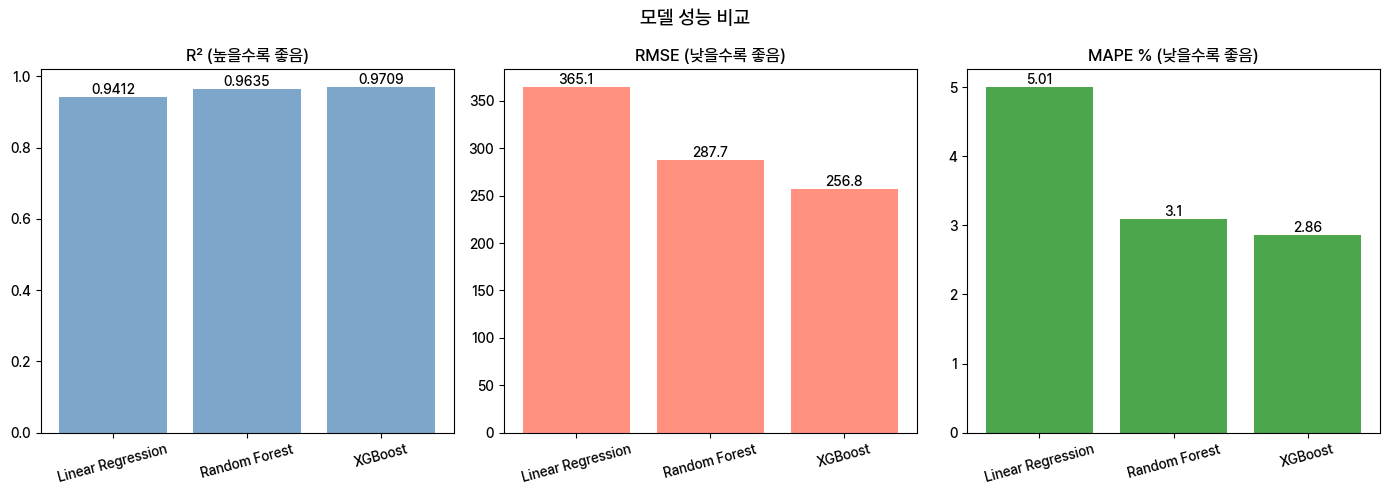

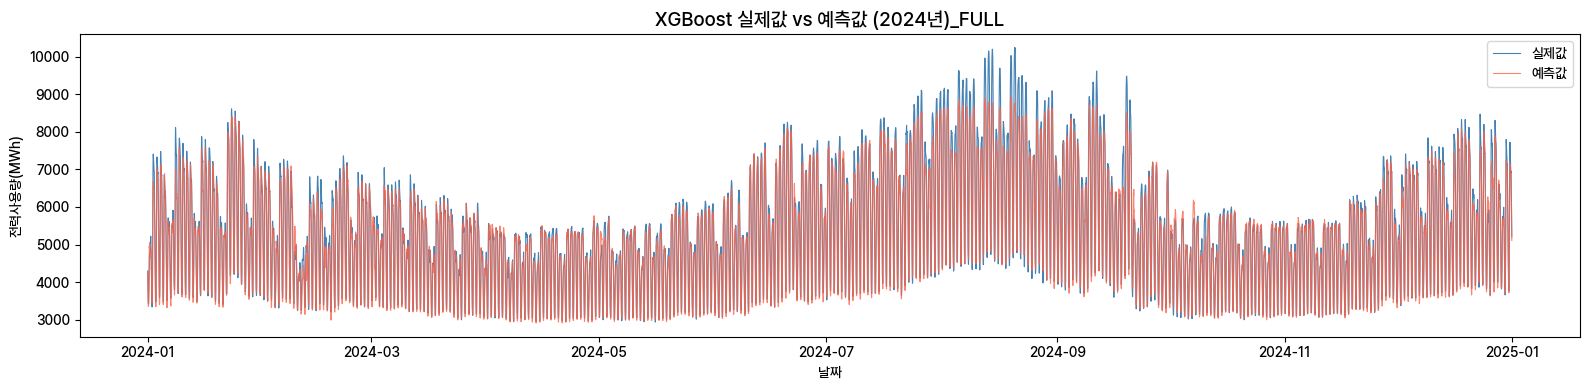

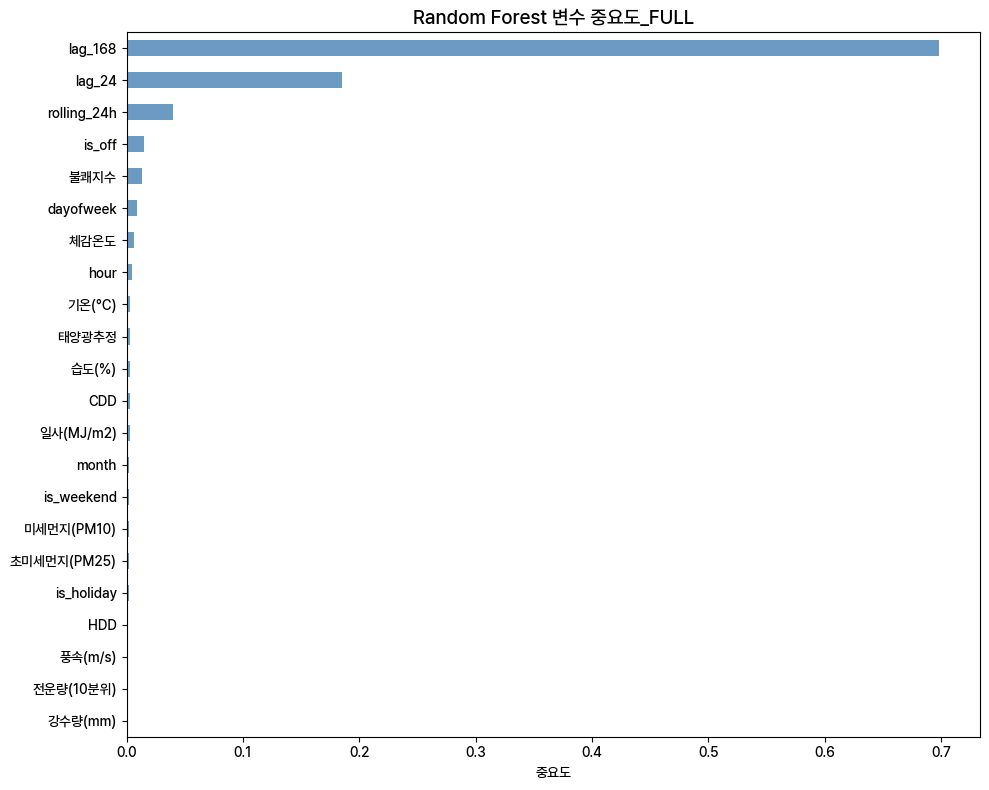

In [8]:
# ── 피처 / 타겟 정의 ────────────────────────────
FEATURES = [
    "기온(°C)", "강수량(mm)", "풍속(m/s)", "습도(%)", "일사(MJ/m2)", "전운량(10분위)",
    "미세먼지(PM10)", "초미세먼지(PM25)",
    "hour", "dayofweek", "month", "is_weekend", "is_holiday", "is_off",
    "CDD", "HDD", "lag_24", "lag_168", "rolling_24h",
    "체감온도", "불쾌지수", "태양광추정"
]
TARGET = "전력사용량(MWh)"

# 강수량 NaN → 0, 일사량 NaN → 0
df["강수량(mm)"] = df["강수량(mm)"].fillna(0)
df["일사(MJ/m2)"] = df["일사(MJ/m2)"].fillna(0)

# ── 학습/테스트 분리 (2023 → 2024) ─────────────
train = df[df["datetime"].dt.year == 2023]
test  = df[df["datetime"].dt.year == 2024]

X_train = train[FEATURES]
y_train = train[TARGET]
X_test  = test[FEATURES]
y_test  = test[TARGET]

print(f"학습: {X_train.shape} / 테스트: {X_test.shape}")

# ── 모델 학습 ───────────────────────────────────
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest":     RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost":           XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42, n_jobs=-1)
}

results_full = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    results_full[name] = {
        "model": model,
        "pred": pred,
        "R2":   round(r2_score(y_test, pred), 4),
        "RMSE": round(np.sqrt(mean_squared_error(y_test, pred)), 1),
        "MAPE": round(mean_absolute_percentage_error(y_test, pred) * 100, 2)
    }
    print(f"{name:20s} | R²: {results_full[name]['R2']} | RMSE: {results_full[name]['RMSE']} | MAPE: {results_full[name]['MAPE']}%")

# ── 성능 비교표 시각화 ──────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
metrics = ["R2", "RMSE", "MAPE"]
titles  = ["R² (높을수록 좋음)", "RMSE (낮을수록 좋음)", "MAPE % (낮을수록 좋음)"]
colors  = ["steelblue", "tomato", "green"]

for i, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
    vals = [results_full[m][metric] for m in models]
    axes[i].bar(list(models.keys()), vals, color=color, alpha=0.7)
    axes[i].set_title(title, fontsize=12)
    for j, v in enumerate(vals):
        axes[i].text(j, v, str(v), ha="center", va="bottom", fontsize=10)
    axes[i].tick_params(axis='x', rotation=15)

plt.suptitle("모델 성능 비교", fontsize=14)
plt.tight_layout()
plt.savefig(r"C:\Users\User\Desktop\MyRepo\Portfolio\Portfolio_ver2\4_outputs\모델_성능비교.png", dpi=300)
plt.show()

# ── 실제값 vs 예측값 시각화 (XGBoost) ──────────
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(test["datetime"].values, y_test.values, label="실제값", color="steelblue", linewidth=0.8)
ax.plot(test["datetime"].values, results_full["XGBoost"]["pred"], label="예측값", color="tomato", linewidth=0.8, alpha=0.8)
ax.set_title("XGBoost 실제값 vs 예측값 (2024년)_FULL", fontsize=14)
ax.set_xlabel("날짜")
ax.set_ylabel("전력사용량(MWh)")
ax.legend()
plt.tight_layout()
plt.savefig(r"C:\Users\User\Desktop\MyRepo\Portfolio\Portfolio_ver2\4_outputs\실제vs예측.png", dpi=300)
plt.show()

# ── 변수 중요도 (Random Forest) ─────────────────
fi = pd.Series(
    results_full["Random Forest"]["model"].feature_importances_,
    index=FEATURES
).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
fi.plot(kind="barh", ax=ax, color="steelblue", alpha=0.8)
ax.set_title("Random Forest 변수 중요도_FULL", fontsize=14)
ax.set_xlabel("중요도")
plt.tight_layout()
plt.savefig(r"C:\Users\User\Desktop\MyRepo\Portfolio\Portfolio_ver2\4_outputs\변수중요도.png", dpi=300)
plt.show()

In [9]:
# ── 4개 모델 최종 비교 (XGBoost 기준) ──────────
print("=" * 55)
print(f"{'모델':<15} | {'RMSE':>8} | {'R²':>8} | {'MAPE':>8}")
print("=" * 55)
for name, results in [
    ("Baseline", results_baseline),
    ("LAG model", results_lag),
    ("ENV Model",  results_env),
    ("Full Model", results_full),
]:
    r = results["XGBoost"]
    print(f"{name:<15} | {r['RMSE']:>8} | {r['R2']:>8} | {r['MAPE']:>7}%")
print("=" * 55)

모델              |     RMSE |       R² |     MAPE
Baseline        |    651.8 |   0.8126 |    8.75%
LAG model       |    254.2 |   0.9715 |    2.89%
ENV Model       |    477.7 |   0.8993 |    7.59%
Full Model      |    256.8 |   0.9709 |    2.86%


In [10]:
# LAG Model 오차 상위 5% 구간
error_lag = np.abs(y_test.values - results_lag["XGBoost"]["pred"])
top5_mask = error_lag >= np.percentile(error_lag, 95)

# 그 구간의 기온 분포
print(test.loc[top5_mask, "기온(°C)"].describe())

count    440.000000
mean      23.556818
std       10.931295
min      -11.200000
25%       19.875000
50%       27.400000
75%       31.600000
max       36.300000
Name: 기온(°C), dtype: float64


In [11]:
# LAG 오차 큰 구간에서 두 모델 비교
print(f"LAG  오차 상위 5% RMSE : {np.sqrt(mean_squared_error(y_test[top5_mask], results_lag['XGBoost']['pred'][top5_mask])):.1f}")
print(f"Full 오차 상위 5% RMSE : {np.sqrt(mean_squared_error(y_test[top5_mask], results_full['XGBoost']['pred'][top5_mask])):.1f}")

LAG  오차 상위 5% RMSE : 815.7
Full 오차 상위 5% RMSE : 711.2
